# Backpack Kaggle Competition
### W207 Final Project - Spring 2025

Team: Perry Gabriel, Aurelia Yang

University of California, Berkeley

## Description

In this competition, participants are challenged to develop machine learning models to predict the price of a backpack based on various features. This is a great opportunity to test your skills, learn new techniques, and compete with others in the data science community.

## Evaluation

Submissions are evaluated on the root mean squared error between the predicted and actual price of the backpack.

RMSE is defined as:
$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

where $y_i$ is the actual price of the backpack and $\hat{y}_i$ is the predicted price of the backpack.

## Data Description

The data consists of the following columns:

- `id`: A unique identifier for the backpack.
- `Brand`: The brand of the backpack.
- `Material`: The material of the backpack.
- `Size`: The size of the backpack.
- `Compartments`: The number of compartments in the backpack.
- `Laptop Compartment`: Whether the backpack has a laptop compartment.
- `Waterproof`: Whether the backpack is waterproof.
- `Style`: The style of the backpack.
- `Color`: The color of the backpack.
- `Weight Capacity (kg)`: The weight capacity of the backpack in kilograms.
- `Price`: The price of the backpack.

## Data Splits
The dataset is split into three parts:
- **Train**: The training set contains 80% of the data and is used to train the model.
- **Validation**: The validation set contains 10% of the data and is used to tune the model.
- **Test**: The test set contains 10% of the data and is used to evaluate the model's performance.

## Important Notes about the Dataset
- There are (4) different datasets: train, train_extra, test, and sample_submission.
- The `train` dataset contains the training data with the target variable `Price`.
- The `train_extra` dataset contains additional training data that can be used to improve the model's performance.
- The `test` dataset contains the test data without the target variable `Price`.
- The `sample_submission` dataset contains a sample submission file with the correct format.
- The `train` and `train_extra` datasets are combined to create a larger training set.
- The `train_extra` dataset was provided by the competition organizers and is not part of the original dataset.

## Submission File

For each `id` in the test set, you must predict the price of the backpack. The file should contain a header and have the following format:

```python
id,Price
1,100
2,200
3,300
```

## Timeline

- **Start Date** - February 1, 2025
- **Entry Deadline** - Same as the Final Submission Deadline
- **Team Merger Deadline** - Same as the Final Submission Deadline
- **Final Submission Deadline** - February 28, 2025

All deadlines are at 11:59 PM UTC on the corresponding day unless otherwise noted. The competition organizers reserve the right to update the contest timeline if they deem it necessary.

## Acknowledgements

This dataset was created by [Kaggle](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset) for the purpose of hosting a competition.

## Team Members

- [Perry Gabriel](https://www.kaggle.com/prgabriel)
- [Aurelia Yang](https://www.kaggle.com/aureliayang)

## Sections

1. [Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Modeling](#3.-Modeling)
4. [Evaluation](#4.-Evaluation)
5. [Optimization](#5.-Optimization)
6. [Final Submission](#6.-Final-Submission)
7. [Conclusion](#7.-Conclusion)

## References
[Backpack Kaggle Competition Link](https://www.kaggle.com/competitions/playground-series-s5e2)

[Backpack Kaggle Competition Dataset](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset)


## 0. Setup
Install the required libraries
Uncomment to download the data from Kaggle. This assumes you have the Kaggle API installed and configured.

In [1]:
# !kaggle competitions download -c playground-series-s5e2
# !unzip playground-series-s5e2 -d ../data/raw/
# !pip install -r ../requirements.txt
# !rm -rf playground-series-s5e2.zip

In [2]:
import os
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #used to supress the tf version warning. 

In [3]:
mlflow.set_experiment(experiment_name='E2E_Kaggle_Backpack_Project')
# mlflow.set_tracking_uri("colab")
mlflow.autolog()

2025/03/31 00:12:09 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/31 00:12:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.
2025/03/31 00:12:11 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 2.1.3, but the installed version is 2.1.4. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/03/31 00:12:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


In [4]:
raw_data_path = '../data/raw/'

In [5]:
%pip install google.colab

def check_and_import_colab():
    global raw_data_path
    global processed_path
    try:
        from google.colab import drive  
        import google.colab
        print("Running on Google Colab")
        # Import necessary libraries for Google Colab
        drive.mount('/content/drive')

        # define paths
        raw_data_path = "/content/drive/MyDrive/Kaggle_Backpack/data/raw/"
        processed_path = "/content/drive/MyDrive/Kaggle_Backpack/data/processed/"
        return True

    except ImportError:
        print("Not running on Google Colab")
        os.makedirs(raw_data_path, exist_ok=True)
        print("Created 'raw_data_path' directory for non-Colab Environment.")
        return False

on_colab = check_and_import_colab()

ERROR: Could not find a version that satisfies the requirement google.colab (from versions: none)
ERROR: No matching distribution found for google.colab
Note: you may need to restart the kernel to use updated packages.
Not running on Google Colab
Created 'raw_data_path' directory for non-Colab Environment.


## 1. Exploratory Data Analysis

In this section, we will explore the data to understand its structure and identify any patterns or trends that may be present.


### 1.1 Load the Data

Let's start by loading the data and taking a look at the first few rows.

In [6]:
train_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'train.csv'), index_col=0, header=0, sep=',')
test_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'test.csv'), index_col=0, header=0, sep=',')
train_extra_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_path, 'training_extra.csv'), index_col=0, header=0, sep=',')

train_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [7]:
test_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg)
id,,,,,,,,,
300000,Puma,Leather,Small,2.0,No,No,Tote,Green,20.671147
300001,Nike,Canvas,Medium,7.0,No,Yes,Backpack,Green,13.564105
300002,Adidas,Canvas,Large,9.0,No,Yes,Messenger,Blue,11.809799
300003,Adidas,Nylon,Large,1.0,Yes,No,Messenger,Green,18.477036
300004,NaN,Nylon,Large,2.0,Yes,Yes,Tote,Black,9.907953


In [8]:
train_extra_df.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
500000,Under Armour,Canvas,Small,10.0,Yes,Yes,Tote,Blue,23.882052,114.11068
500001,Puma,Polyester,Small,4.0,No,Yes,Backpack,Green,11.869095,129.74972
500002,Jansport,Polyester,Small,8.0,Yes,Yes,Tote,Red,8.092302,21.37370
500003,Nike,Nylon,Large,7.0,No,No,Messenger,Pink,7.719581,48.09209
500004,Nike,Leather,Large,9.0,No,Yes,Tote,Green,22.741826,77.32461


### 1.2 Data Summary

Next, let's take a look at the summary statistics of the data.


In [9]:
# Display the summary statistics of the training data
train_df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [10]:
test_df.describe()

,Compartments,Weight Capacity (kg)
count,200000.000000,199923.000000
mean,5.442855,17.993033
std,2.888740,6.972079
min,1.000000,5.000000
25%,3.000000,12.068875
50%,5.000000,18.054750
75%,8.000000,23.965700
max,10.000000,30.000000


In [11]:
train_extra_df.describe()

,Compartments,Weight Capacity (kg),Price
count,3.694318e+06,3.692648e+06,3.694318e+06
mean,5.434022e+00,1.800883e+01,8.135820e+01
std,2.893227e+00,6.974541e+00,3.893050e+01
min,1.000000e+00,5.000000e+00,1.500000e+01
25%,3.000000e+00,1.206854e+01,4.747778e+01
50%,5.000000e+00,1.805243e+01,8.098592e+01
75%,8.000000e+00,2.398580e+01,1.148434e+02
max,1.000000e+01,3.000000e+01,1.500000e+02


Let's see the data types of each column.

In [12]:
print(f"Data types of columns in training dataset\n{train_df.dtypes}\n")
print(f"Data types of columns in training extra dataset\n{train_extra_df.dtypes}\n")
print(f"Data types of columns in testing dataset\n{test_df.dtypes}\n")

Data types of columns in training dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in training extra dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
Price                   float64
dtype: object

Data types of columns in testing dataset
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style  

Let's get the shape of the data.

In [13]:
# Display the shape of the dataset.
print(f"Shape of training data: {train_df.shape}")
print(f"Shape of training extra data: {train_extra_df.shape}")
print(f"Shape of testing data: {test_df.shape}")

Shape of training data: (300000, 10)
Shape of training extra data: (3694318, 10)
Shape of testing data: (200000, 9)


Now, let's combine the train and train_extra datasets to create a larger training set.

In [14]:
# Combine train and train_extra datasets
train_df = pd.concat([train_df, train_extra_df], axis=0).reset_index(drop=True)

# Display the shape of the combined dataset
print(f"Shape of combined training data: {train_df.shape}")

# Display the shape of the combined dataset
train_df.shape

# Display the first few rows of the combined dataset
train_df.head()


Shape of combined training data: (3994318, 10)


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


Let's capture the categories of the categorical variables.

In [15]:
cat_columns = train_df.columns[:-2].tolist()  # Dropped the last two columns since we know that these are numerical columns
print(f'There are {len(cat_columns)} categorical columns:')
print(cat_columns)

num_columns = [train_df.columns[-2]]
print(f'There are {len(num_columns)} numerical column:')
print(num_columns)

There are 8 categorical columns:
['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
There are 1 numerical column:
['Weight Capacity (kg)']


### 1.3 Data Visualization

We created visualizations to better understand the data.


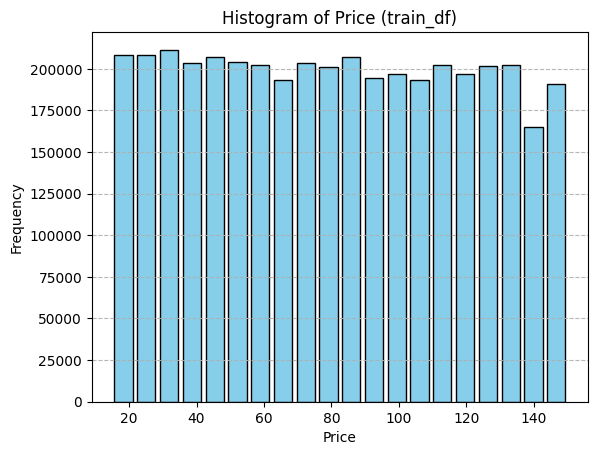

In [16]:
# For example, plot a histogram of the price column
plt.hist(train_df['Price'], bins=20, edgecolor='black', color='skyblue', rwidth=0.8)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (train_df)')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.show()

### 1.4 Correlation Matrix

Finally, let's create a correlation matrix to see how the features are related to each other.


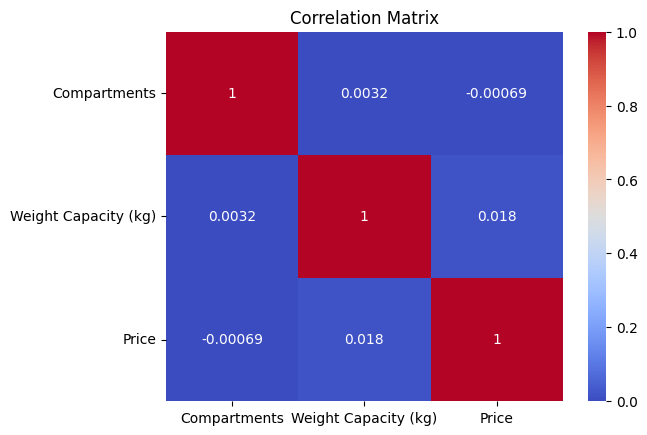

In [17]:
# Select only the numeric columns
numeric_cols = train_df.select_dtypes(include=['float64', 'int64'])

# Create a correlation matrix
corr = numeric_cols.corr()

# Display the correlation matrix
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### Observations so far: 

- `training_extra` has significantly more records (3.69M) than `training` (300k), which will be useful in improving model training.
- Some categorical columns have substantial missing values:
    - `Brand`: 9705 missing in `train`, 117,000 missing in `train_extra`
    - `Material`, `Style`, `Color`
- `train_extra` has a higher proportion of missing values.
- Considering:
    - Mode imputation for categorical columns
    - Mean/median imputation for numerical columns


### 1.5 Feature Distribution

Let's take a look at the distribution of the features.

In [18]:
# # define numerical and categorical cols
# num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
# cat_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# # remove price
# num_cols.remove('Price')

# # feature distribution comparison train.csv vs train_extra.csv
# plt.figure(figsize=(12, 5))
# sns.kdeplot(train_df['Price'], label='Train', fill=True)
# sns.kdeplot(train_extra_df['Price'], label='Train Extra', fill=True)
# plt.legend()
# plt.title("Price Distribution Comparison (Train vs Train Extra)")
# plt.xlabel("Price")
# plt.ylabel("Density")
# plt.show()


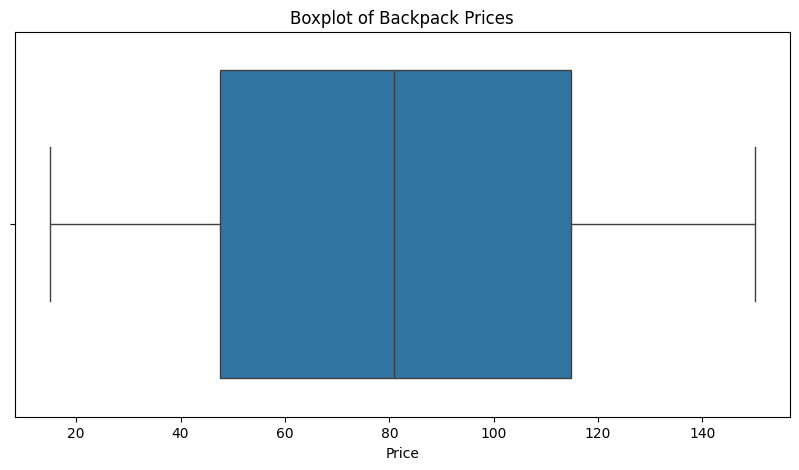

In [19]:
# outlier boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(x=train_df["Price"])
plt.title("Boxplot of Backpack Prices")
plt.show()

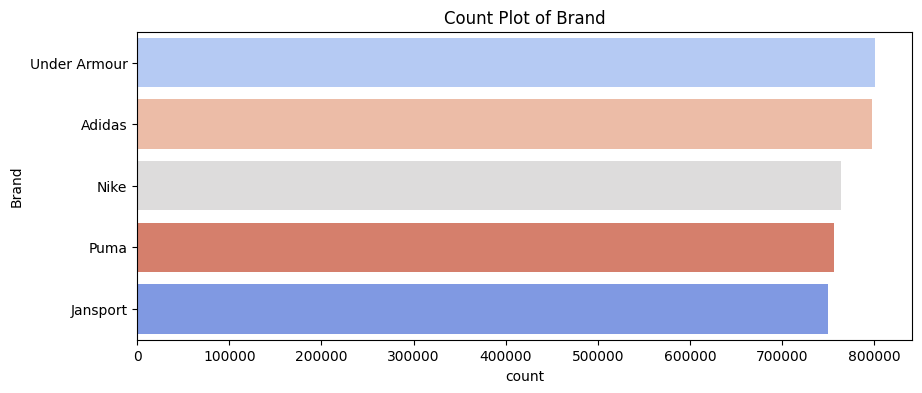

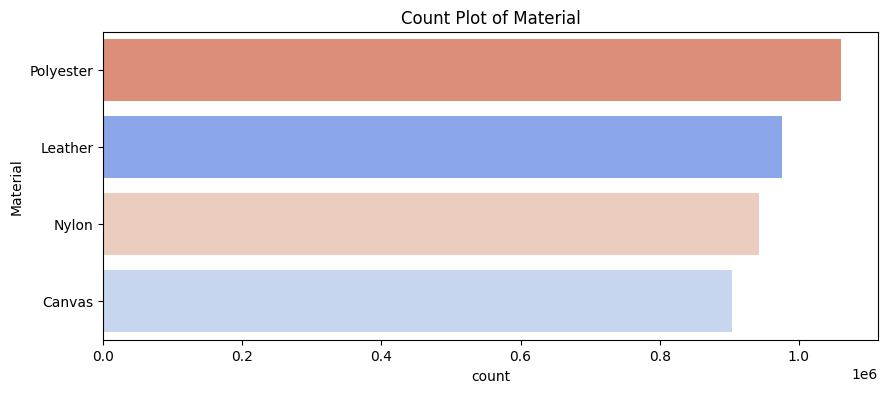

In [ ]:
# categorical feature distribution
for col in cat_columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index, hue=train_df[col], palette="coolwarm", legend=False)
    plt.title(f"Count Plot of {col}")
    plt.show()


### Observations: Data Loading and Preprocessing

#### Outlier Analysis
- Slightly right-skewed distribution.
- Consider removing outliers?

#### Correlation Matrix
- Weight capacity is slightly positively correlated with price (0.2).
- Categorical feature impact on price needs boxplots by category -> build this out.

#### Categorical Feature Distribution
- No glaring abnormalities.

## 2. Data Preprocessing

In this section, we will preprocess the data to prepare it for modeling.

### 2.1 Missing Values

First, let's check for missing values in the data and decide how to handle them.

In [ ]:
# train_df.isnull().sum()

In [ ]:
# train_extra_df.isnull().sum()

In [ ]:
# test_df.isnull().sum()

Let's fill in missing values categorical values with mode and numerical values with forward fill for both training datasets and test data.

In [ ]:
# # combine train and train_extra
# train_combined = pd.concat([train_df, train_extra_df], axis=0).reset_index(drop=True)

# # fill categorical with mode, others forward fill
# for col in cat_cols:
#     train_combined[col] = train_combined[col].fillna(train_combined[col].mode()[0])
# test_df = test_df.ffill()

# for col in num_cols:
#     train_combined[col] = train_combined[col].fillna(train_combined[col].median())
# test_df[num_cols] = test_df[num_cols].fillna(test_df[num_cols].median())

# # one-hot encode (nominal categorical features)
# ohe_cols = ['Brand', 'Color', 'Style']
# train_encoded_df = pd.get_dummies(train_combined, columns=ohe_cols, drop_first=True)
# test_encoded_df = pd.get_dummies(test_df, columns=ohe_cols, drop_first=True)

# # ensure test set has same features as train
# train_cols = train_encoded_df.columns
# test_encoded_df = test_encoded_df.reindex(columns=train_cols, fill_value=0)

# # ordinal feature label encoding
# le_cols = ['Material', 'Size']
# le = LabelEncoder()
# for col in le_cols:
#     train_encoded_df[col] = le.fit_transform(train_combined[col])
#     test_encoded_df[col] = le.transform(test_df[col])


### 2.2 Feature Engineering

In this section, we will create new features that may help improve the performance of our models.


Creation of Combined (Combined_list) Features

For each original categorical column, a new feature is generated by combining it with Weight Capacity.

This is done to create a new feature that captures the interaction between the original categorical feature and the weight capacity of the backpack. The new feature is created by multiplying the weight capacity by 100 and adding it to the original categorical feature. This allows us to create a new feature that captures the interaction between the original categorical feature and the weight capacity of the backpack.

In [ ]:
combined_list = []
label_encoders = {}

for c in cat_columns:  # Use 'cat_columns' as defined earlier in the notebook
    # Initialize and fit a LabelEncoder for the current column
    le = LabelEncoder()
    combined = pd.concat([train_df[c], test_df[c]], axis=0)
    le.fit(combined)
    label_encoders[c] = le  # Store the encoder for potential future use

    # Transform the train and test data
    train_df[c] = le.transform(train_df[c])
    test_df[c] = le.transform(test_df[c])

    # Create a new column combining the encoded value and weight capacity
    new_col = f"{c}_Weight_Capacity_Combined"
    train_df[new_col] = train_df[c] * 100 + train_df["Weight Capacity (kg)"]
    test_df[new_col] = test_df[c] * 100 + test_df["Weight Capacity (kg)"]

    # Append the new column name to the combined_list list
    combined_list.append(new_col)

print(f"We now have {len(combined_list)} new columns")
print(combined_list)

In [ ]:
input_variables = cat_columns + num_columns + combined_list
print(f"We now have {len(input_variables)} columns:")
print(input_variables)

### Distance Features (feture_distance)
- `feature_Distance` is a new feature that captures the distance between the backpack and the user.
- It is created by taking the absolute difference between the weight capacity and the average weight capacity of the backpacks in the dataset.
- This feature is useful because it captures the distance between the backpack and the user, which can be important for predicting the price of the backpack.


In [ ]:
# Define the columns to be used for distance calculations
distance_columns = ['Brand', 'Material', 'Size', 'Style', 'Color']

# Ensure the columns are encoded numerically
label_encoders = {}
for col in distance_columns:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0)
    le.fit(combined)
    label_encoders[col] = le
    train_df[col] = le.transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

# Function to calculate distance features
def calculate_distance_features(df, columns):
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            col1, col2 = columns[i], columns[j]
            new_col = f"{col1}_{col2}_Distance"
            df[new_col] = np.sqrt((df[col1] - df[col2]) ** 2)
    return df

# Apply the function to train and test datasets
train_df = calculate_distance_features(train_df, distance_columns)
test_df = calculate_distance_features(test_df, distance_columns)

# Display the new columns added
distance_features = [col for col in train_df.columns if '_Distance' in col]
print(f"Distance features added: {distance_features}")

In [ ]:
# Group Aggregations
agg_features = {}
group_cols = ['Weight Capacity (kg)'] + combined_list  # Group by Weight Capacity and combo features
agg_funcs = ['mean', 'std', 'min', 'max', 'median', 'count', 'skew']

for col in group_cols:
    agg = train_df.groupby(col)['Price'].agg(agg_funcs).reset_index()
    agg.columns = [col] + [f"{col}_Price_{func}" for func in agg_funcs]
    train_df = train_df.merge(agg, on=col, how='left')
    test_df = test_df.merge(agg, on=col, how='left')
    agg_features.update({col: agg.columns[1:]})



Grouping operations were performed to compute statistical metrics such as mean, standard deviation, min, max, median, count, and skew across various feature combinations. Aggregations were applied based on `Weight Capacity (kg)` and the features in the combined_list, helping to uncover meaningful interactions in the data.

Additionally, Target Encoding was applied to the columns in base_features. Each categorical value was replaced with the smoothed average Price within its category, enabling the model to better capture the relationship between categorical features and the target variable.

In [ ]:
# Target Encoding
base_features = ['Brand', 'Material', 'Size', 'Style', 'Color']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for col in base_features:

    # Initialize the column with a compatible data type (float64)
    train_df[f"{col}_TE"] = 0.0  # Explicitly set to float64

    for train_idx, val_idx in kf.split(train_df):
        train_fold, val_fold = train_df.iloc[train_idx], train_df.iloc[val_idx]
        means = train_fold.groupby(col)['Price'].mean()
        train_df.loc[val_idx, f"{col}_TE"] = val_fold[col].map(means)
        
    test_df[f"{col}_TE"] = test_df[col].map(train_df.groupby(col)['Price'].mean())

# Fill NaN values in test_df after mapping
test_df.fillna(test_df.mean(), inplace=True)

print("Group Aggregations and Target Encoding completed.")

In [ ]:
# # feature engineering - interaction terms
# train_encoded_df["Price_per_Compartment"] = train_encoded_df["Price"] / (train_encoded_df["Compartments"] + 1)
# train_encoded_df["Has_Laptop_Compartment"] = train_encoded_df["Laptop Compartment"].apply(lambda x: 1 if x == "Yes" else 0)

# # standardization (scale numerical features)
# scaler = StandardScaler()
# train_encoded_df[num_cols] = scaler.fit_transform(train_encoded_df[num_cols])
# test_encoded_df[num_cols] = scaler.transform(test_encoded_df[num_cols])

In [ ]:
# # Check to see the changes
# train_encoded_df.isnull().sum()


In [ ]:
# test_encoded_df.isnull().sum()

Now, lets save the data to a new csv file under processed_data folder.

Provided the code to save the data to a new csv file under processed_data folder. However, the size of the file is too large to be uploaded to GitHub. So, for now, we will not upload the processed data and will use the raw data for modeling.

In [ ]:
# # Save the processed data to the appropriate location
# if on_colab:
#     # Save processed data to Google Drive
#     train_fold.to_csv(os.path.join(processed_path, "train_fold.csv"), index=False)
#     val_fold.to_csv(os.path.join(processed_path, "val_fold.csv"), index=False)
#     print("Processed train and validation folds saved to Google Drive.")
# else:
#     # Check if the directory exists, if not, create it
#     processed_file_path = '../data/processed'
#     if not os.path.exists(processed_file_path):
#         os.makedirs(processed_file_path)

#     # Save the processed train and validation data locally
#     train_fold.to_csv(os.path.join(processed_file_path, "train_fold.csv"), index=False)
#     val_fold.to_csv(os.path.join(processed_file_path, "val_fold.csv"), index=False)
#     print("Processed train and validation folds saved to local drive.")

In [ ]:
# # Checks to see if this notebook is running on Google Colab and save to the recommended locations. 
# if on_colab:
#     # save processed data to drive
#     train_encoded_df.to_csv(os.path.join(processed_path, "train_final.csv"), index=False)
#     test_encoded_df.to_csv(os.path.join(processed_path, "test_final.csv"), index=False)
#     print("Feature engineering completed - processed files saved on Google Drive.")
# else:
#     # Check if the directory exists, if not, create it
#     processed_file_path = '../data/processed'
#     if not os.path.exists(processed_file_path):
#         os.makedirs(processed_file_path)

#     # Save the transformed training data
#     train_encoded_df.to_csv(processed_file_path + '/train_processed.csv', index=True)
#     processed_train_encoded_df = train_encoded_df.copy()

#     # Save the transformed testing data
#     test_encoded_df.to_csv(processed_file_path + '/test_processed.csv', index=True)
#     processed_test_encoded_df = test_encoded_df.copy()
#     print("Feature engineering completed - processed files saved to Non-Colab Environment Local Drive.")

### Observations so far ### 

TODO:
Delete this section

- Merged train and train_extra datasets
- Dropped id column
- OHE for brand, color and style
- Performed label encoding for material and size columns
- Added feature interactions
  - price_per_compartment, has_laptop_compartment
- mode imputation for categorical columns missing vals
- forward fill for numerical columns missing vals
- saved processed data to processed_data folder

## 3. Modeling

In this section, we will select and train machine learning models to predict the price of the backpack.


In [ ]:
processed_file_path = '../data/processed'

if on_colab:
    train_final_df = pd.read_csv(os.path.join(processed_path, "train_final.csv"))
    test_final_df = pd.read_csv(os.path.join(processed_path, "test_final.csv"))

    print("Train Final Shape:", train_final_df.shape)
    print("Test Final Shape:", test_final_df.shape)

    display(train_final_df.head(3))
    display(test_final_df.head(3))
else:
    train_final_df = pd.read_csv(os.path.join(processed_file_path, "train_processed.csv"))
    test_final_df = pd.read_csv(os.path.join(processed_file_path, "test_processed.csv"))

    print("Train Final Shape:", train_final_df.shape)
    print("Test Final Shape:", test_final_df.shape)

    display(train_final_df.head())
    display(test_final_df.head())

# Drop the 'id' and 'Unnamed: 0' columns from the datasets
train_final_df.drop(columns=['Unnamed: 0'], inplace=True)
test_final_df.drop(columns=['id'], inplace=True)

# Verify the changes
print(train_final_df.head())
print(test_final_df.head())

train_final_df.columns

# Ensure 'Price' column is present before dropping
if 'Price' in train_final_df.columns:
	# Select the target feature
	y = train_final_df['Price']

	# Drop the target feature from the training dataframe
	X = train_final_df.drop(columns=['Price'])

	# Verify the changes
	print(X.head())
	print(y.head())
else:
	print("'Price' column is not present in train_final_df")

# Check the shape of X, and y
print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

# leftover cat cols
obj_cols = X.select_dtypes(include=['object']).columns
print("Object columns:", obj_cols)

### 3.1 Train-Test Split

First, let's split the data into training and testing sets.

In [ ]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# convert cat to numerical
X_train["Laptop Compartment"] = X_train["Laptop Compartment"].map({"Yes": 1, "No": 0})
X_train["Waterproof"] = X_train["Waterproof"].map({"Yes": 1, "No": 0})
X_val["Laptop Compartment"] = X_val["Laptop Compartment"].map({"Yes": 1, "No": 0})
X_val["Waterproof"] = X_val["Waterproof"].map({"Yes": 1, "No": 0})


### 3.2 Model Selection

Next, let's select a model to train on the data.

In [ ]:
# baseline model
lr_model = LinearRegression().fit(X_train, y_train)
lr_model

In [ ]:
# Define the XGBoost model
xgb_model = XGBRegressor(
    n_estimators=1_000,
    learning_rate=0.02,
    subsample=0.9,
    max_depth=6,
    random_state=42,
    verbosity=1
)

# Train the model on the training data
xgb_model.fit(
    train_fold.drop(columns=['Price']), 
    train_fold['Price'], 
    eval_set=[(val_fold.drop(columns=['Price']), val_fold['Price'])], 
    early_stopping_rounds=10, 
    verbose=True
)

# Predict on the validation set
y_pred_xgb = xgb_model.predict(X_val)

# Calculate RMSE for the XGBoost model
rmse_xgb = root_mean_squared_error(y_val, y_pred_xgb, squared=False)
print("Baseline XGBoost RMSE:", rmse_xgb)

## 4. Evaluation

In this section, we will evaluate the performance of our models using various metrics.


In [ ]:
# Generate our y_hat value with y_pred_lr variable.
y_pred_lr = lr_model.predict(X_val)

rmse_lr = root_mean_squared_error(y_val, y_pred_lr)
print("Baseline Linear Regression RMSE:", rmse_lr)

In [ ]:
# Calculate residuals
residuals = y_val - y_pred_lr

# Plot baseline and residuals
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_lr, alpha=0.3)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Baseline Model: Predicted vs Actual Price')
plt.show()

# Plot distribution of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

### Observations

#### Residual Distribution
- There is a large spike near residual = 0, indicating that, on average, the baseline model predictions are close to the actual price for many backpacks.
- Wide spread, heavy tails: Residuals extend from about -60 to +60, suggesting that for some backpacks, the baseline model underpredicts by up to 60 units and overpredicts by up to 60 units. A high variance in residuals suggests significant differences in how well the linear baseline model captures the data across different price ranges/categories.
- RMSE is very high: 25.03. While many predictions cluster around 0, there is still a lot of deviation.

#### Predicted vs Actual Price
- Points spread out well above and below the diagonal, meaning the baseline model error is not constant across the price range. The baseline model may overestimate some backpack prices (points above the red line) and underestimate others (points below the red line).
- There are multiple lines in the predicted values, indicating that the linear baseline model is grouping certain types of backpacks (perhaps by brand, color, or other splits) and producing similar predictions for them. This effect is more pronounced in linear baseline models when strong interactions are not fully captured.

#### Overall
- The baseline captures some positive relationship, but there is significant variance in the predictions with clear clusters at certain price ranges. The high error spread suggests the relationship cannot be captured by a simple linear baseline model and certain features may be missing.
- The multiple lines indicate that combining certain features leads to the same predicted price, so we may explore adding more interaction terms or exploring a non-linear baseline model next, such as a random forest.



## 5. Model Optimization

In this section, we will optimize the hyperparameters of our models to improve their performance.


## 6. Final Submission

In this section, we will select the best model and make final predictions on the test set.


## 7. Conclusion

In this section, we will summarize our findings and discuss the implications of our results.